## Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook shows how to process your own 2D or 3D images, saved on Google Drive.

This notebook is adapted from the notebook by Pradeep Rajasekhar, inspired by the [ZeroCostDL4Mic notebook series](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

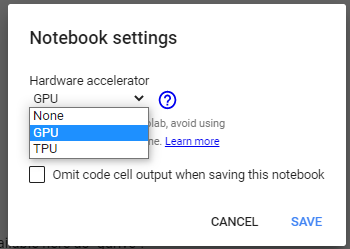

### Mount your google drive

Run this cell to connect your Google Drive to colab:
* Click on the URL.
* Sign in your Google Account.

You will either have to:
* copy the authorisation code and enter it into box below OR
* in the new google colab, you can just click "Allow" and it should connect.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Then click on "Folder" icon on the Left, press the refresh button. Your Google Drive folder should now be available here as "gdrive".


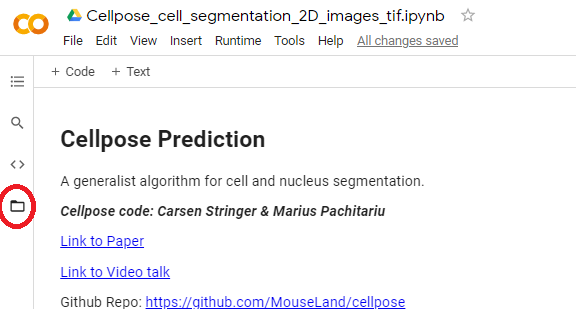

Click on the triangle icon and it will allow you to access whole drive. Navigate to the folder containing your images. Once you are there, click on the three dots on the right of the folder and select "Copy Path"

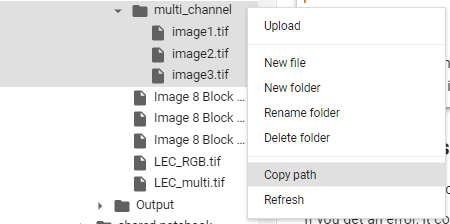

Copy and paste this path in the **dir** string below

### Install Cellpose-SAM


In [ ]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-j1k_ud9u
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-j1k_ud9u
  Resolved https://www.github.com/mouseland/cellpose.git to commit 15eb3c6831ac19e0948dbc38c11016d11d1aacf3
  Preparing metadata (setup.py) ... done


Check GPU and instantiate model - will download weights.

In [ ]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
from natsort import natsorted

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

2025-06-17 18:05:31,087 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-06-17 18:05:31,088 [INFO] 
cellpose version: 	4.0.5.dev23+g15eb3c6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-06-17 18:05:31,089 [INFO] ** TORCH CUDA version installed and working. **
2025-06-17 18:05:31,090 [INFO] ** TORCH CUDA version installed and working. **
2025-06-17 18:05:31,091 [INFO] >>>> using GPU (CUDA)
2025-06-17 18:05:34,309 [INFO] >>>> loading model /root/.cellpose/models/cpsam


Input directory with your images:

In [ ]:
# *** change to your google drive folder path ***
dir = "/content/drive/MyDrive/ResUnet 3D/Test/x"
dir = Path(dir)

dir2 = "/content/drive/MyDrive/ResUnet 3D/Results 2 Google Colab"
dir2 = Path(dir2)

if not dir.exists():
  raise FileNotFoundError("directory does not exist")

# *** change to your image extension ***
image_ext = ".tif"

# list all files
files = natsorted([f for f in dir.glob("*"+image_ext) if "_masks" not in f.name and "_flows" not in f.name])

if(len(files)==0):
  raise FileNotFoundError("no image files found, did you specify the correct folder and extension?")
else:
  print(f"{len(files)} images in folder:")

for f in files:
  print(f.name)

21 images in folder:
20240903_MatWRi_Ed633_Dlg568008_Series001_4.tif
20240903_MatWRi_Ed633_Dlg568008_Series001_5.tif
20240903_MatWRi_Ed633_Dlg568008_Series002_7.tif
20240903_MatWRi_Ed633_Dlg568011_Series001_8.tif
20240905_MatWRi_Ed633_Dlg568001_Series001_2.tif
20240905_MatWRi_Ed633_Dlg568002_Series002_2.tif
20240905_MatWRi_Ed633_Dlg568003_Series001_1.tif
20240905_MatWRi_Ed633_Dlg568004_Series001_4.tif
20240905_MatWRi_Ed633_Dlg568004_Series001_8.tif
20240905_MatWRi_Ed633_Dlg568004_Series002_3.tif
20240911_MatWRi_Ed633_Dlg568002_Series001_5.tif
20240911_MatWRi_Ed633_Dlg568002_Series001_10.tif
20240911_MatWRi_Ed633_Dlg568002_Series002_5.tif
20240911_MatWRi_Ed633_Dlg568003_Series002_8.tif
20240911_MatWRi_Ed633_Dlg568004_Series002_8.tif
20240918_sdk_Dlg568002-Series002_9.tif
20240918_sdk_Dlg568003-Series001_2.tif
20240918_sdk_Dlg568003-Series002_4.tif
20240920_sdk_Dlg568001-Series001_1.tif
20240920_sdk_Dlg568001-Series001_8.tif
20240920_sdk_Dlg568001-Series002_10.tif


## Run Cellpose-SAM on one image in folder

Here are some of the parameters you can change:

* ***flow_threshold*** is  the  maximum  allowed  error  of  the  flows  for  each  mask.   The  default  is 0.4.
    *  **Increase** this threshold if cellpose is not returning as many masks as you’d expect (or turn off completely with 0.0)
    *   **Decrease** this threshold if cellpose is returning too many ill-shaped masks.

* ***cellprob_threshold*** determines proability that a detected object is a cell.   The  default  is 0.0.
    *   **Decrease** this threshold if cellpose is not returning as many masks as you’d expect or if masks are too small
    *   **Increase** this threshold if cellpose is returning too many masks esp from dull/dim areas.

* ***tile_norm_blocksize*** determines the size of blocks used for normalizing the image. The default is 0, which means the entire image is normalized together.
  You may want to change this to 100-200 pixels if you have very inhomogeneous brightness across your image.



In [ ]:
img = io.imread(files[0])

print(f'your image has shape: {img.shape}. Assuming channel dimension is last with {img.shape[-1]} channels')

2025-06-17 18:05:58,932 [INFO] reading tiff with 90 planes


100%|██████████| 90/90 [00:00<00:00, 520.67it/s]

your image has shape: (90, 256, 256). Assuming channel dimension is last with 256 channels


### Channel Selection:

- Use the dropdowns below to select the _zero-indexed_ channels of your image to segment. The order does not matter. Remember to rerun the cell after you edit the dropdowns.

- If you have a histological image taken in brightfield, you don't need to adjust the channels.

- If you have a fluroescent image with multiple stains, you should choose one channel with a cytoplasm/membrane stain, one channel with a nuclear stain, and set the third channel to `None`. Choosing multiple channels may produce segmentaiton of all the structures in the image. If you have retrained the model on your data with a thrid stain (described below), you can run segmentation with all channels.

In [ ]:
first_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
second_channel = '0' # @param ['None', 0, 1, 2, 3, 4, 5]
third_channel = 'None' # @param ['None', 0, 1, 2, 3, 4, 5]

Since the images are stacks with a single membrane stain (cell contours) and you don't have a nuclear channel, the correct Cellpose channel configuration is:

first_channel: 0
second_channel: 0
third_channel: None (or leave it empty if possible)

This tells Cellpose to use the same channel (0) for both cytoplasm and nucleus (even if there is no nucleus), which is the recommended practice when you only have one informative channel (membrane) and want to obtain instance segmentation based on that channel.

2025-06-17 18:06:03,713 [WARNING] channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
2025-06-17 18:06:03,714 [WARNING] Found more than 3 channels, only using first 3


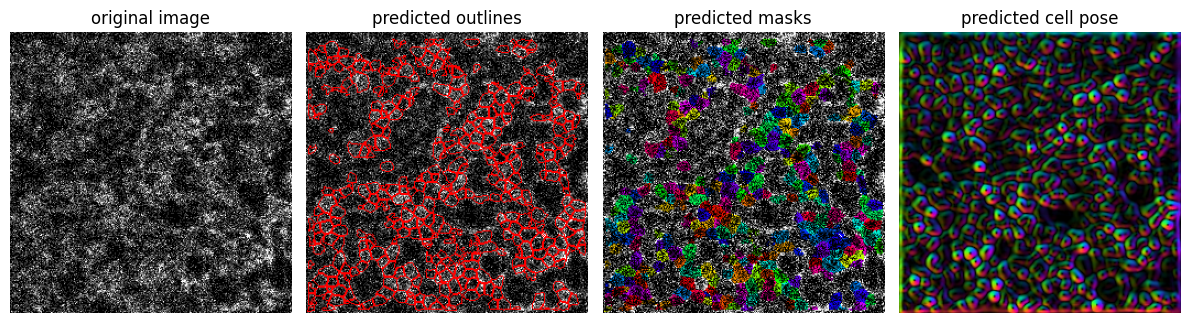

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import plot
from skimage import io

selected_channels = []
# Assuming the first dimension is z and we are selecting channels within each z-slice
# The user mentioned the images are z-stacks with a single membrane stain (channel 0)
# We will select only the first channel for segmentation and plotting
if first_channel != 'None':
    selected_channels.append(int(first_channel))
if second_channel != 'None' and int(second_channel) not in selected_channels:
     selected_channels.append(int(second_channel))
if third_channel != 'None' and int(third_channel) not in selected_channels:
     selected_channels.append(int(third_channel))


# Check if the selected channel indices are valid for the given image shape
# We assume the channel dimension is the last one if it exists and has size > 1
if img.ndim == 3 and img.shape[-1] > 1:
    for c in selected_channels:
        if c >= img.shape[-1]:
             assert False, f'invalid channel index {c}, must have index less than the number of channels ({img.shape[-1]})'
elif img.ndim == 2:
     if len(selected_channels) > 0 and int(selected_channels[0]) != 0:
          assert False, f'invalid channel index {selected_channels[0]}, for 2D image only channel 0 is valid'
else:
    # Handle potential 3D images which are not multi-channel (e.g. z-stacks)
    # In this case, selected_channels should probably only contain 0
    if len(selected_channels) > 0 and int(selected_channels[0]) != 0:
         assert False, f'invalid channel index {selected_channels[0]}, for 3D image without explicit channels, only channel 0 is considered'


# For plotting, we will use the first z-slice.
# Assuming img is a 3D z-stack (z, y, x) and we want to plot the first slice.
if img.ndim == 3:
    img_for_plotting = img[0] # Select the first z-slice
elif img.ndim == 2:
    img_for_plotting = img # If it's already 2D, use as is
else:
    # Handle other dimensions if necessary, but for now assume 2D or 3D z-stack
    img_for_plotting = img


# For segmentation, we will use the original image and the selected channels configuration
# Cellpose eval function handles channel selection based on the 'channels' parameter.
# We will pass the channel configuration to the model.eval function later.


flow_threshold = 1.0
cellprob_threshold = 0.0
tile_norm_blocksize = 200

# Pass the channel configuration to model.eval using the channels parameter
# If selected_channels is empty or contains only 0, Cellpose will use the first channel.
# If selected_channels has two elements, Cellpose assumes [cytoplasm, nucleus].
# If selected_channels has three elements, Cellpose assumes [cytoplasm, nucleus, optional_channel].
# Given your description of a single membrane stain, passing [0, 0] or [0] or leaving it as None might be appropriate.
# Let's use [0, 0] based on the markdown cell JRrup2TafSzJ
channels_config = [0, 0] if len(selected_channels) == 0 or (len(selected_channels) == 1 and selected_channels[0] == 0) else selected_channels


masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize}, channels=channels_config)

# Based on the output provided, masks is a 2D array and flows is a list.
# We will pass the 2D masks array and the first element of the flows list to the plotting function.
fig = plt.figure(figsize=(12,5))
# Use the image prepared for plotting (should be 2D) and the masks and flows for the first slice
plot.show_segmentation(fig, img_for_plotting, masks, flows[0]) # Pass the 2D masks and the first element of flows
plt.tight_layout()
plt.show()

## Run Cellpose-SAM on folder of images

if you have many large images, you may want to run them as a loop over images



In [ ]:
masks_ext = ".png" if image_ext == ".png" else ".tif"
for i in trange(len(files)):
    f = files[i]
    img = io.imread(f)
    masks, flows, styles = model.eval(img, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

    # io.imsave(dir / (f.stem + "_masks" + masks_ext), masks[i])

    io.imsave(dir2 / (f.stem + "_masks" + masks_ext), masks[i])


  0%|          | 0/21 [00:00<?, ?it/s]

2025-06-17 18:13:51,951 [WARNING] Found more than 3 channels, only using first 3


  5%|▍         | 1/21 [00:01<00:38,  1.92s/it]

2025-06-17 18:13:53,861 [WARNING] Found more than 3 channels, only using first 3


 10%|▉         | 2/21 [00:03<00:34,  1.82s/it]

2025-06-17 18:13:55,618 [WARNING] Found more than 3 channels, only using first 3


 14%|█▍        | 3/21 [00:05<00:31,  1.77s/it]

2025-06-17 18:13:57,342 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:13:58,882 [INFO] No cell pixels found.


 19%|█▉        | 4/21 [00:07<00:29,  1.72s/it]

2025-06-17 18:13:58,970 [WARNING] Found more than 3 channels, only using first 3


 24%|██▍       | 5/21 [00:08<00:27,  1.72s/it]

2025-06-17 18:14:00,692 [WARNING] Found more than 3 channels, only using first 3


 29%|██▊       | 6/21 [00:10<00:26,  1.73s/it]

2025-06-17 18:14:02,452 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:04,029 [INFO] No cell pixels found.


 33%|███▎      | 7/21 [00:12<00:23,  1.71s/it]

2025-06-17 18:14:04,103 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:05,687 [INFO] No cell pixels found.


 38%|███▊      | 8/21 [00:13<00:22,  1.69s/it]

2025-06-17 18:14:05,791 [WARNING] Found more than 3 channels, only using first 3


 43%|████▎     | 9/21 [00:15<00:20,  1.73s/it]

2025-06-17 18:14:07,588 [WARNING] Found more than 3 channels, only using first 3


 48%|████▊     | 10/21 [00:17<00:19,  1.75s/it]

2025-06-17 18:14:09,374 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:10,945 [INFO] No cell pixels found.


 52%|█████▏    | 11/21 [00:19<00:17,  1.72s/it]

2025-06-17 18:14:11,025 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:12,565 [INFO] No cell pixels found.


 57%|█████▋    | 12/21 [00:20<00:15,  1.69s/it]

2025-06-17 18:14:12,644 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:14,169 [INFO] No cell pixels found.


 62%|██████▏   | 13/21 [00:22<00:13,  1.67s/it]

2025-06-17 18:14:14,264 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:15,781 [INFO] No cell pixels found.


 67%|██████▋   | 14/21 [00:23<00:11,  1.65s/it]

2025-06-17 18:14:15,859 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:17,361 [INFO] No cell pixels found.


 71%|███████▏  | 15/21 [00:25<00:09,  1.63s/it]

2025-06-17 18:14:17,486 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:18,999 [INFO] No cell pixels found.


 76%|███████▌  | 16/21 [00:27<00:08,  1.63s/it]

2025-06-17 18:14:19,135 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:20,656 [INFO] No cell pixels found.


 81%|████████  | 17/21 [00:28<00:06,  1.64s/it]

2025-06-17 18:14:20,745 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:22,255 [INFO] No cell pixels found.


 86%|████████▌ | 18/21 [00:30<00:04,  1.63s/it]

2025-06-17 18:14:22,344 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:23,817 [INFO] No cell pixels found.


 90%|█████████ | 19/21 [00:31<00:03,  1.61s/it]

2025-06-17 18:14:23,903 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:25,385 [INFO] No cell pixels found.


 95%|█████████▌| 20/21 [00:33<00:01,  1.60s/it]

2025-06-17 18:14:25,483 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:26,961 [INFO] No cell pixels found.


100%|██████████| 21/21 [00:35<00:00,  1.67s/it]


if you have small images, you may want to load all of them first and then run, so that they can be batched together on the GPU

In [ ]:
print("loading images")
imgs = [io.imread(files[i]) for i in trange(len(files))]

print("running cellpose-SAM")
masks, flows, styles = model.eval(imgs, batch_size=32, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold,
                                  normalize={"tile_norm_blocksize": tile_norm_blocksize})

print("saving masks")
for i in trange(len(files)):
    f = files[i]
    io.imsave(dir2 / (f.stem + "_masks" + masks_ext), masks[i])

loading images


100%|██████████| 21/21 [00:01<00:00, 15.17it/s]

running cellpose-SAM
2025-06-17 18:14:48,411 [INFO] 0%|          | 0/21 [00:00<?, ?it/s]
2025-06-17 18:14:48,412 [WARNING] Found more than 3 channels, only using first 3


2025-06-17 18:14:50,085 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:51,654 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:53,216 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:54,649 [INFO] No cell pixels found.
2025-06-17 18:14:54,659 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:56,275 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:57,813 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:14:59,252 [INFO] No cell pixels found.
2025-06-17 18:14:59,259 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:15:00,723 [INFO] No cell pixels found.
2025-06-17 18:15:00,730 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:15:02,356 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:15:03,973 [WARNING] Found more than 3 channels, only using first 3
2025-06-17 18:15:05,468 [INFO] 

100%|██████████| 21/21 [00:13<00:00,  1.54it/s]


to save your masks for ImageJ, run the following code:

In [ ]:
for i in trange(len(files)):
    f = files[i]
    # Correctly save the mask data using io.imsave
    # Assuming 'masks' is a list of masks from the previous cell's execution (XH-K72hGDr5n)
    # and masks[i] corresponds to the mask for files[i]
    save_path = Path(save_dir)
    io.imsave(dir2 / (f.name + "_masks" + masks_ext), masks[i])
    # Removing the incorrect io.save_rois call

100%|██████████| 21/21 [00:13<00:00,  1.56it/s]


Run Cellpose-SAM in 3D (Adapted by Javier)

In [ ]:
import tifffile
import numpy as np
import os
from skimage import io

# Especifica la ruta completa de destino donde quieres guardar las imágenes
output_dir = "/content/drive/MyDrive/TFM JAVIER/Results CellPose -- SAM - actualizado"

# Especifica el directorio de entrada con las imágenes
input_dir = "/content/drive/MyDrive/TFM JAVIER/ResUnet 3D GoldStandard - BiaPy/Test/x"

# Lista de archivos en el directorio de entrada
image_files = os.listdir(input_dir)

# Itera sobre los archivos en el directorio
for image_file in image_files:
    # Verifica si el archivo es una imagen .tif (ajustar según sea necesario)
    if image_file.endswith(".tif"):
        # Ruta completa de la imagen
        input_image_path = os.path.join(input_dir, image_file)

        # Carga la imagen
        img_3D = io.imread(input_image_path)

        # Aquí iría el código que ejecuta el modelo Cellpose
        masks, flows, _ = model.eval(img_3D, z_axis=0, channel_axis=1, batch_size=32,
                                     do_3D=True, flow3D_smooth=1, diameter=50)

        # Extrae el nombre del archivo sin la extensión
        base_name = os.path.basename(input_image_path).split('.')[0]

        # Crea el nuevo nombre del archivo con el sufijo "_cellposemask3d"
        output_filename = base_name + "_CellPoseMask3D.tif"

        # Guarda las máscaras 3D en la ruta especificada con el nuevo nombre
        tifffile.imwrite(os.path.join(output_dir, output_filename), masks.astype(np.uint16))
        print(f"Guardada: {output_filename}")